In [274]:
from cmlreaders import CMLReader, get_data_index
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy
from scipy import stats

In [275]:
#sites = ['Dartmouth', 'Jefferson','Emory', 'UTSW', 'Penn']
sites = 'All'
BAI_high = 15
BAI_low = 8
BDI_high = 16
BDI_low = 10

sel_sub = pd.DataFrame([])
df = pd.read_excel(r'./All_neuropsych.xlsx')
# for site in sites:
#     df = pd.read_excel(r'./' + site + '_neuropsych.xlsx',engine="openpyxl")
#     df = pd.read_excel(r'./' + site + '_neuropsych.xlsx')
for i in df.index:
    #gap = df.iloc[i]['Time between report and implant (days)']
    sub = df.iloc[i]['Subject Number']
    BDI = df.iloc[i]['BDI']
    BAI = df.iloc[i]['BAI']
    #if gap < 183 and np.isnan(BDI)==False and np.isnan(BAI)==False:
    if np.isnan(BDI)==False or np.isnan(BAI)==False:
        sel_sub = sel_sub.append({
            'subject':sub,
            'site':site,
            'BDI':BDI,
            'BAI':BAI
            }, ignore_index = True)
sel_sub

,BAI,BDI,site,subject
0,8.0,2.0,Penn,1.0
1,9.0,0.0,Penn,2.0
2,7.0,7.0,Penn,6.0
3,NaN,16.0,Penn,7.0
4,0.0,2.0,Penn,8.0
...,...,...,...,...
229,24.0,30.0,Penn,587.0
230,10.0,12.0,Penn,588.0
231,15.0,18.0,Penn,591.0
232,6.0,0.0,Penn,593.0


In [276]:
df = get_data_index('r1')
df_subs = df['subject'].unique()
df_select = pd.DataFrame([])
df_subs
tmp = []
select = []
for sub in df_subs:
    num = int(sub[2:5])
    for i in sel_sub.index:
        sel = sel_sub.iloc[i]['subject']
        if sel == num:
            df_select = df_select.append({
                'subject':sub,
                'BDI':sel_sub.iloc[i]['BDI'],
                'BAI':sel_sub.iloc[i]['BAI']
                }, ignore_index = True)
df_select[0:50]

,BAI,BDI,subject
0,8.0,2.0,R1001P
1,9.0,0.0,R1002P
2,7.0,7.0,R1006P
3,0.0,2.0,R1008J
4,2.0,1.0,R1010J
5,2.0,12.0,R1013E
6,NaN,23.0,R1014D
7,7.0,15.0,R1015J
8,NaN,11.0,R1016M
9,0.0,2.0,R1018P


In [285]:
sub = 'R1108J'
row = df_select[df_select['subject']==sub]
row['BAI'].item()

1.0

In [287]:
trial_df = pd.DataFrame([])
list_df = pd.DataFrame([])

experiments = ['FR1', 'catFR1']

for sub in df_select['subject']:
#   try:
    for exp in experiments:
        localizations=df[(df['subject']==sub) & (df['experiment']==exp)]['localization'].unique()        

        for loc in localizations:
            montages = df[(df['subject']==sub) & (df['experiment']==exp) & (df['localization']==loc)]['montage'].unique()            

            for mont in montages: # iterate over montages            
                data = df[np.logical_and(df["subject"] == sub, df['experiment']==exp)]
                sessions=data[np.logical_and(data['montage']==mont,data['localization']==loc)]['session'].unique()

                for sess in sessions: 
                    reader = CMLReader(sub, exp, sess, montage=mont, localization=loc)   #reader for loading CML data
                    evs = reader.load('task_events')
                    word_evs = evs[evs['type']=='REC_WORD']

                    #exclude practice lists 
                    lists = len(word_evs['list'][word_evs['list']>0].unique()) 
                    corr_recs = len(word_evs[word_evs['intrusion']==0])
                    ELIs = len(word_evs[word_evs['intrusion']==-1])
                    PLIs = len(word_evs[word_evs['intrusion']>0])
                    total_ints = ELIs + PLIs
                    total_trials = corr_recs + total_ints

                    trials = [] #make list of event numbers of analysis
                    for list_num in word_evs['list'][word_evs['list']>0].unique():
                        list_events=word_evs[word_evs['list']==list_num]
                        if len(list_events)>0: 
                            for i in range(0,len(list_events)):
                                trials.append(list_events.index[i])
                        PLI = len(list_events[list_events['intrusion']>0])
                        ELI = len(list_events[list_events['intrusion']==-1])
                        correc = len(list_events[list_events['intrusion']==0])
                        row = df_select[df_select['subject']==sub] #get row of BAI/BDI scores for subject
                        BAI = row['BAI'].item()
                        BDI = row['BDI'].item()
#                         if np.isnan(row['BAI'].item())==False and np.isnan(row['BDI'].item())==False:
#                             BAI = int(row['BAI'])
#                             BDI = int(row['BDI'])
#                         elif np.isnan(row['BAI'].item())==True:
#                             BAI = np.nan
#                             BDI = int(row['BDI'])
#                         elif np.isnan(row['BDI'].item())==True:
#                             BAI = int(row['BAI'])
#                             BDI = np.nan
                        list_df = list_df.append({ #create dataframe of events for analysis grouped by list ##should I filter out lists with no events?
                            'subject':sub,
                            'session': sess,
                            'experiment': exp,
                            'list': list_num,
                            'number of correct recalls': correc,
                            'number of extra-list intrusions': ELI,
                            'number of prior-list intrusions': PLI,
                            'total number of intrusions': ELI+PLI,
                            'BAI':BAI,
                            'BDI':BDI
                            },ignore_index=True) 
                    trial_df = trial_df.append({ #create dataframe of events for analysis grouped by session
                        'subject':sub,
                        'session': sess,
                        'montage': mont,
                        'localization': loc,
                        'experiment': exp,
                        'number of lists': lists,
                        'number of correct recalls': corr_recs,
                        'number of extra-list intrusions': ELIs,
                        'number of prior-list intrusions': PLIs,
                        'total number of intrusions': total_ints,
                        'total number of trials left': total_trials,
                        'trials for analysis': trials
                        },ignore_index=True) 
#     except:
#         print('Failed for subject:', sub)
list_df[:100]

,BAI,BDI,experiment,list,number of correct recalls,number of extra-list intrusions,number of prior-list intrusions,session,subject,total number of intrusions
0,8.0,2.0,FR1,2.0,2.0,0.0,2.0,0.0,R1001P,2.0
1,8.0,2.0,FR1,3.0,4.0,3.0,1.0,0.0,R1001P,4.0
2,8.0,2.0,FR1,4.0,2.0,3.0,1.0,0.0,R1001P,4.0
3,8.0,2.0,FR1,7.0,2.0,2.0,0.0,0.0,R1001P,2.0
4,8.0,2.0,FR1,8.0,3.0,1.0,1.0,0.0,R1001P,2.0
...,...,...,...,...,...,...,...,...,...,...
95,7.0,7.0,FR1,1.0,4.0,1.0,0.0,0.0,R1006P,1.0
96,7.0,7.0,FR1,2.0,3.0,1.0,1.0,0.0,R1006P,2.0
97,7.0,7.0,FR1,3.0,3.0,1.0,0.0,0.0,R1006P,1.0
98,7.0,7.0,FR1,4.0,5.0,1.0,1.0,0.0,R1006P,2.0


In [288]:
any(np.isnan(list_df['BDI']))
# list_df.query("subject=='R1014D'")

True

In [289]:
trial_df.query("experiment=='FR1'")

,experiment,localization,montage,number of correct recalls,number of extra-list intrusions,number of lists,number of prior-list intrusions,session,subject,total number of intrusions,total number of trials left,trials for analysis
0,FR1,0.0,0.0,62.0,21.0,22.0,25.0,0.0,R1001P,46.0,108.0,"[63, 64, 66, 67, 88, 89, 90, 91, 92, 93, 95, 9..."
1,FR1,0.0,0.0,63.0,19.0,23.0,17.0,1.0,R1001P,36.0,99.0,"[38, 39, 40, 41, 62, 63, 64, 65, 66, 67, 68, 8..."
2,FR1,0.0,0.0,117.0,3.0,25.0,8.0,0.0,R1002P,11.0,128.0,"[38, 39, 40, 41, 67, 68, 69, 70, 71, 74, 95, 9..."
3,FR1,0.0,0.0,120.0,2.0,25.0,3.0,1.0,R1002P,5.0,125.0,"[38, 39, 40, 41, 42, 43, 44, 65, 66, 67, 68, 6..."
4,FR1,0.0,0.0,106.0,9.0,25.0,21.0,0.0,R1006P,30.0,136.0,"[38, 39, 40, 42, 43, 66, 67, 68, 69, 72, 93, 9..."
...,...,...,...,...,...,...,...,...,...,...,...,...
471,FR1,0.0,0.0,63.0,5.0,12.0,1.0,1.0,R1542J,6.0,69.0,"[70, 71, 72, 73, 106, 107, 108, 109, 110, 111,..."
472,FR1,0.0,0.0,70.0,1.0,12.0,2.0,2.0,R1542J,3.0,73.0,"[70, 71, 72, 73, 106, 107, 108, 109, 110, 111,..."
473,FR1,0.0,0.0,92.0,2.0,12.0,1.0,3.0,R1542J,3.0,95.0,"[72, 73, 75, 76, 77, 110, 111, 112, 113, 114, ..."
474,FR1,0.0,0.0,90.0,3.0,12.0,2.0,4.0,R1542J,5.0,95.0,"[73, 74, 75, 76, 77, 78, 79, 112, 113, 114, 11..."


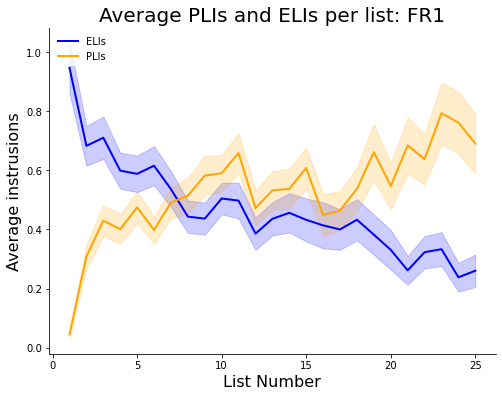

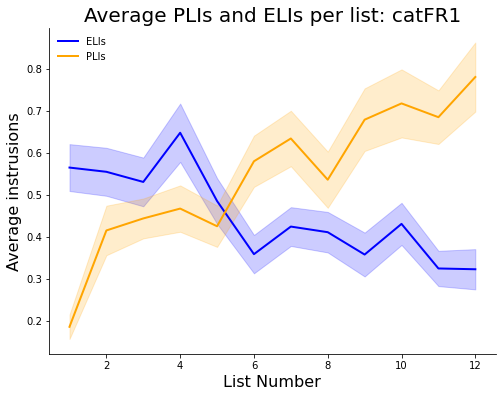

In [290]:
#BEGINNING OF LIST-LEVEL ANALYSES
experiments = ['FR1', 'catFR1']
colors = ['blue', 'orange']

#Create dataframe of recall type averaged over list number
exp_sum_df = pd.DataFrame([])
for exp in experiments:
    if exp=='FR1':
        nlist = 25
    elif exp=='catFR1': ##there are 30 subjects who ran CatFR1 with 25 lists rather than 12. Need to figure out how to interpret the second half of those sessions
        nlist = 12
    for i in range(1,nlist+1):
        exp_list_df = list_df[list_df['experiment']==exp]
        list_sel = exp_list_df[exp_list_df['list']==i]
        correc = np.mean(list_sel['number of correct recalls'])
        ELI = np.mean(list_sel['number of extra-list intrusions'])
        ELI_sem = scipy.stats.sem(list_sel['number of extra-list intrusions'],axis=0,ddof=1,nan_policy='omit')
        PLI = np.mean(list_sel['number of prior-list intrusions'])
        PLI_sem = scipy.stats.sem(list_sel['number of prior-list intrusions'],axis=0,ddof=1,nan_policy='omit')
        exp_sum_df = exp_sum_df.append({
            'experiment':list_sel.iloc[0]['experiment'],
            'list':i,
            'average correct recalls':correc,
            'average ELIs':ELI,
            'ELI_sem':ELI_sem,
            'average PLIs':PLI,
            'PLI_sem':PLI_sem
        }, ignore_index=True)
    
    sel_sum_df = exp_sum_df.query("experiment=='"+exp+"'")
    #sel_sum_df = exp_sum_df[exp_sum_df['experiment']==exp]
    lst = list(sel_sum_df['list'])
    meanELIs = sel_sum_df['average ELIs']
    meanPLIs = sel_sum_df['average PLIs']
    semELIs = sel_sum_df['ELI_sem']
    semPLIs = sel_sum_df['PLI_sem']
    
    plt.figure(figsize=(8,6))
    plt.plot(lst,meanELIs,linewidth=2,color=colors[0])
    plt.fill_between(lst,meanELIs-semELIs,meanELIs+semELIs,color=colors[0],alpha=0.2)
    plt.plot(lst,meanPLIs,linewidth=2,color=colors[1])
    plt.fill_between(lst,meanPLIs-semPLIs,meanPLIs+semPLIs,color=colors[1],alpha=0.2)
    plt.title('Average PLIs and ELIs per list: '+exp, fontsize=20)
    plt.xlabel('List Number',fontsize=16)
    plt.ylabel('Average instrusions',fontsize=16)
    plt.legend(('ELIs','PLIs'),loc='upper left',edgecolor="None")
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    #plt.savefig('PLIvELI '+ exp+ '.pdf')

# long_cat = list_df[np.logical_and(list_df['experiment']==exp, list_df['list']>12)]
# long_cat['subject'].unique()

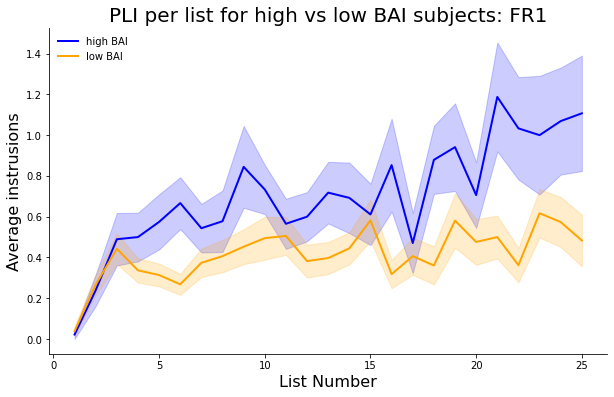

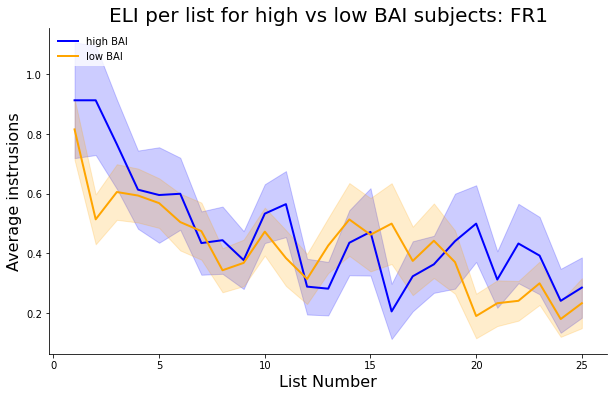

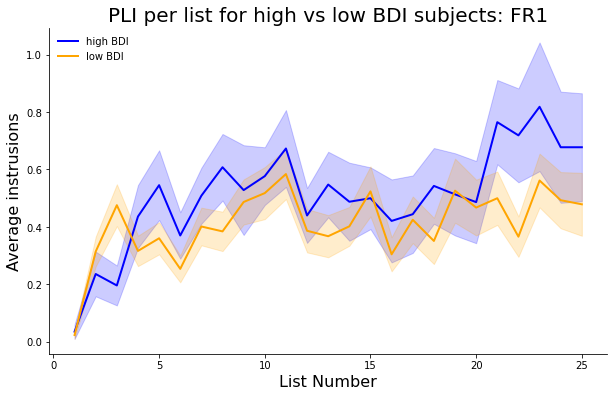

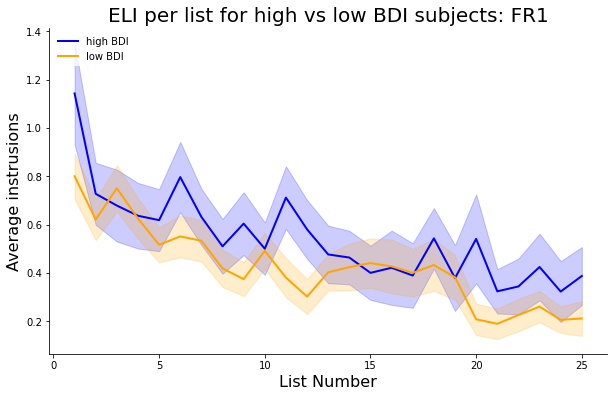

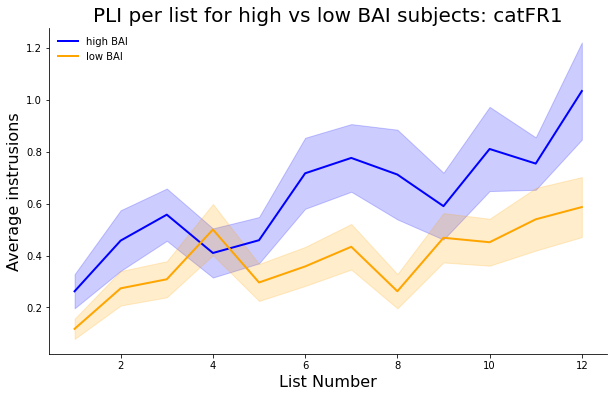

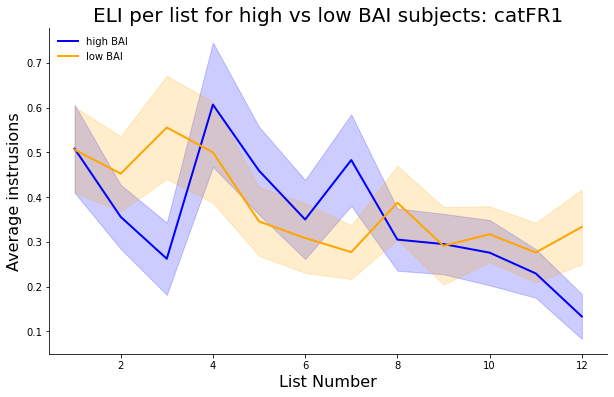

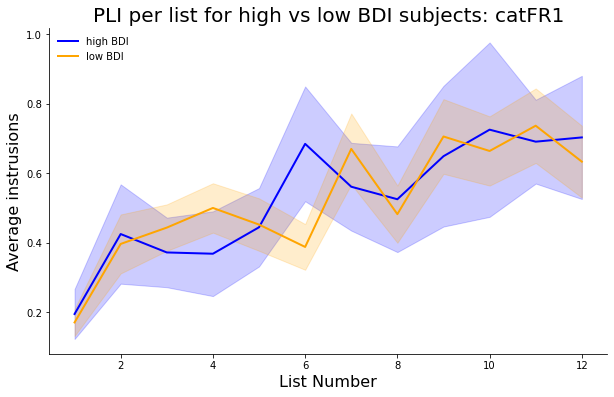

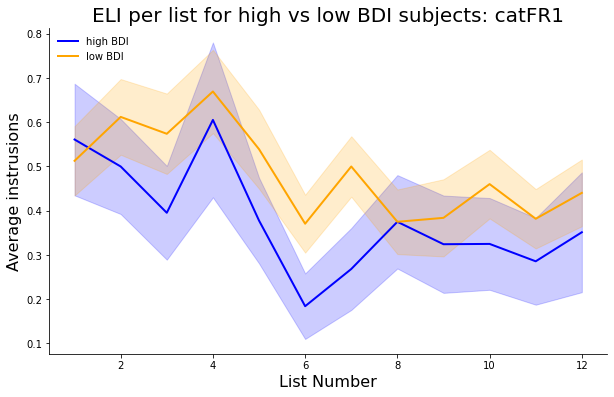

In [291]:
dependents = ['PLI', 'ELI']
metrics = ['BAI','BDI']
levels = ['high','low']

#Compare high and low BAI/BDI subjects for each type of intrusions by list in both experiments
for exp in experiments:
    for met in metrics:
        for dep in dependents:
            split_sum_df = pd.DataFrame([])
            exp_list_df = list_df[list_df['experiment']==exp]
            exp_list_df_highA = exp_list_df[exp_list_df['BAI']>BAI_high]
            exp_list_df_lowA = exp_list_df[exp_list_df['BAI']<BAI_low]
            exp_list_df_highD = exp_list_df[exp_list_df['BDI']>BDI_high]
            exp_list_df_lowD = exp_list_df[exp_list_df['BDI']<BDI_low]
            if exp=='FR1':
                nlist = 25
            elif exp=='catFR1':
                nlist = 12
            if met=='BAI':
                exp_list_df_high = exp_list_df_highA
                exp_list_df_low = exp_list_df_lowA
            elif met=='BDI':
                exp_list_df_high = exp_list_df_highD
                exp_list_df_low = exp_list_df_lowD
            for lev in levels:
                if lev =='high':
                    exp_list_df_filt = exp_list_df_high
                elif lev=='low':
                    exp_list_df_filt = exp_list_df_low
                for i in range(1,nlist+1):
                    list_sel = exp_list_df_filt[exp_list_df_filt['list']==i]
                    correc = np.mean(list_sel['number of correct recalls'])
                    correc_sem = scipy.stats.sem(list_sel['number of correct recalls'],axis=0,ddof=1,nan_policy='omit')
                    ELI = np.mean(list_sel['number of extra-list intrusions'])
                    ELI_sem = scipy.stats.sem(list_sel['number of extra-list intrusions'],axis=0,ddof=1,nan_policy='omit')
                    PLI = np.mean(list_sel['number of prior-list intrusions'])
                    PLI_sem = scipy.stats.sem(list_sel['number of prior-list intrusions'],axis=0,ddof=1,nan_policy='omit')
                    split_sum_df = split_sum_df.append({
                        'experiment':list_sel.iloc[0]['experiment'],
                        'list':i,
                        'average correct recalls':correc,
                        'correct recall_sem':correc,
                        'average ELIs':ELI,
                        'ELI_sem':ELI_sem,
                        'average PLIs':PLI,
                        'PLI_sem':PLI_sem,
                        'metric':met,
                        'level':lev
                    }, ignore_index=True)
            lst = list(split_sum_df['list'].unique())
            high_ints = list(split_sum_df[split_sum_df['level']=='high']['average '+dep+'s'])
            low_ints = list(split_sum_df[split_sum_df['level']=='low']['average '+dep+'s'])
            sem_high = split_sum_df[split_sum_df['level']=='high'][dep+'_sem']
            sem_low = split_sum_df[split_sum_df['level']=='low'][dep+'_sem']

            plt.figure(figsize=(10,6))
            plt.plot(lst,high_ints,linewidth=2,color=colors[0])
            plt.fill_between(lst,high_ints-sem_high,high_ints+sem_high,color=colors[0],alpha=0.2)
            plt.plot(lst,low_ints,linewidth=2,color=colors[1])
            plt.fill_between(lst,low_ints-sem_low,low_ints+sem_low,color=colors[1],alpha=0.2)
            plt.title(dep+' per list for high vs low '+met+' subjects: '+exp, fontsize=20)
            plt.xlabel('List Number',fontsize=16)
            plt.ylabel('Average instrusions',fontsize=16)
            plt.legend(('high '+met,'low '+met),loc='upper left',edgecolor="None")
            plt.gca().spines['right'].set_color('none')
            plt.gca().spines['top'].set_color('none')
            #plt.savefig(dep+' per list for high vs low '+met+' subjects: '+exp+'.pdf')

In [292]:
#Example plot from Noa
colors=['#AFDDD5','#E77577']

mean_low=FR_sum_df_low['average PLIs']
sem_low=FR_sum_df_low['sem PLIs']
mean_high=FR_sum_df_high['average PLIs']
sem_high=FR_sum_df_high['sem PLIs']


# fig=plt.figure(figsize=(5,4.5));#ax=plt.subplot(121)
plt.plot(range(0,len(mean_low)),mean_low,linewidth=2,color=colors[0])
plt.fill_between(range(0,len(mean_low)),mean_low-sem_low,mean_low+sem_low,color=colors[0],alpha=0.2)
plt.plot(range(0,len(mean_high)),mean_high,linewidth=2,color=colors[1])
plt.fill_between(range(0,len(mean_high)),mean_high-sem_high,mean_high+sem_high,color=colors[1],alpha=0.2)

plt.legend(('Low BDI','High BDI'),loc='upper left',edgecolor="None")
plt.xlabel('List number',fontsize=18)
plt.ylabel("PLI's rate",fontsize=18)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['left'].set_color('k')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['bottom'].set_color('k')
# plt.grid(b=None)


NameError: name 'FR_sum_df_low' is not defined

In [293]:
#BEGINNING OF SESSION LEVEL ANALYSES
df_filter = pd.DataFrame([])
#Create dataframe of important session stats. Scale PLIs, ELIs, and correct recalls. Add BAI/BDI scores.
for i in trial_df.index:
    try:
        sub = trial_df.iloc[i]['subject']
        row = df_select[df_select['subject'] == sub]
        eli = trial_df.iloc[i]['number of extra-list intrusions']
        pli = trial_df.iloc[i]['number of prior-list intrusions']
        correc = trial_df.iloc[i]['number of correct recalls']
        allrec = trial_df.iloc[i]['total number of trials left']
        lists = trial_df.iloc[i]['number of lists']
        exp = trial_df.iloc[i]['experiment']
        PLI_scaled = float(pli/correc) ##Need to confirm scaling method with Mike
        ELI_scaled = float(eli/correc)
        correc_scaled = float(correc/lists)
#         PLI_scaled = float(pli/allrec) 
#         ELI_scaled = float(eli/allrec)
#         correc_scaled = float(correc/allrec)
        if allrec > 0: #remove sessions with no valid recalls
            df_filter = df_filter.append({
                'subject':sub,
                'experiment':exp,
                'correct recalls':correc,
                'ELIs':eli,
                'PLIs':pli,
                'total ints': eli+pli,
                'lists':lists,
                'correct recalls scaled':correc_scaled,
                'all recalls':allrec,
                'ELI scaled':ELI_scaled,
                'PLI scaled':PLI_scaled,
                'total scaled':ELI_scaled+PLI_scaled,
                'BAI':int(row['BAI'].values),
                'BDI':int(row['BDI'].values)
            }, ignore_index = True)
        else:
            print('removed row =', i, sub, exp)
    except:
        print('removed row =', i, sub, exp)
df_filter

/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


removed row = 9 R1015J FR1
removed row = 11 R1016M catFR1
removed row = 12 R1016M catFR1
removed row = 15 R1021D catFR1
removed row = 19 R1026D FR1
removed row = 20 R1026D catFR1
removed row = 27 R1034D FR1
removed row = 28 R1034D FR1
removed row = 29 R1034D FR1
removed row = 30 R1035M FR1
removed row = 31 R1035M catFR1
removed row = 34 R1048E FR1
removed row = 72 R1076D FR1
removed row = 73 R1076D FR1
removed row = 74 R1077T FR1
removed row = 75 R1077T FR1
removed row = 76 R1077T FR1
removed row = 77 R1077T FR1
removed row = 100 R1100D FR1
removed row = 101 R1100D FR1
removed row = 115 R1119P catFR1
removed row = 122 R1141T catFR1
removed row = 123 R1141T catFR1
removed row = 124 R1141T catFR1
removed row = 129 R1147P FR1
removed row = 130 R1147P FR1
removed row = 131 R1147P FR1
removed row = 132 R1147P catFR1
removed row = 133 R1148P FR1
removed row = 139 R1155D FR1
removed row = 155 R1187P FR1
removed row = 156 R1187P FR1
removed row = 157 R1187P catFR1
removed row = 158 R1190P catF

,BAI,BDI,ELI scaled,ELIs,PLI scaled,PLIs,all recalls,correct recalls,correct recalls scaled,experiment,lists,subject,total ints,total scaled
0,8.0,2.0,0.338710,21.0,0.403226,25.0,108.0,62.0,2.818182,FR1,22.0,R1001P,46.0,0.741935
1,8.0,2.0,0.301587,19.0,0.269841,17.0,99.0,63.0,2.739130,FR1,23.0,R1001P,36.0,0.571429
2,9.0,0.0,0.025641,3.0,0.068376,8.0,128.0,117.0,4.680000,FR1,25.0,R1002P,11.0,0.094017
3,9.0,0.0,0.016667,2.0,0.025000,3.0,125.0,120.0,4.800000,FR1,25.0,R1002P,5.0,0.041667
4,7.0,7.0,0.084906,9.0,0.198113,21.0,136.0,106.0,4.240000,FR1,25.0,R1006P,30.0,0.283019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2.0,7.0,0.021739,2.0,0.010870,1.0,95.0,92.0,7.666667,FR1,12.0,R1542J,3.0,0.032609
396,2.0,7.0,0.033333,3.0,0.022222,2.0,95.0,90.0,7.500000,FR1,12.0,R1542J,5.0,0.055556
397,2.0,7.0,0.063830,6.0,0.010638,1.0,101.0,94.0,7.833333,FR1,12.0,R1542J,7.0,0.074468
398,2.0,7.0,0.022472,2.0,0.011236,1.0,92.0,89.0,7.416667,catFR1,12.0,R1542J,3.0,0.033708


total PLI = 2000.0
total ELI = 1600.0
mean diff = 0.7634546029413485
median diff = 1.0


Text(0.7634546029413485, 15, '  Mean: 0.0')

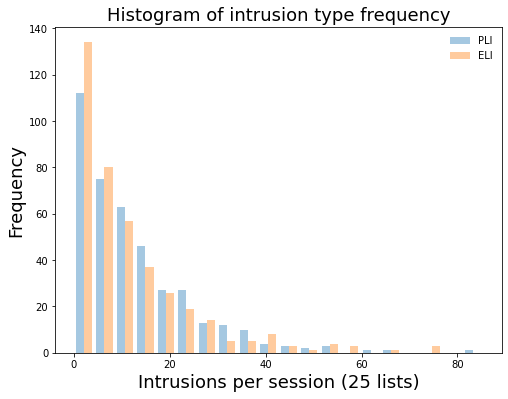

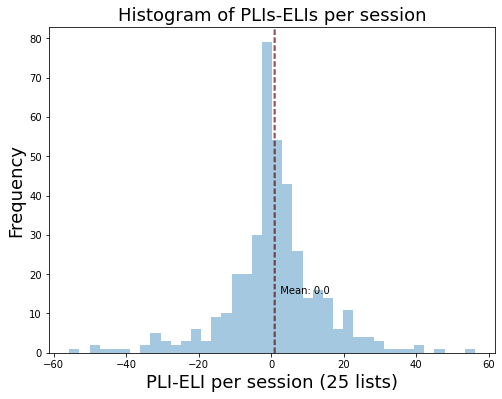

In [294]:
#get intrusion per session counts to generate a histogram
df_int = pd.DataFrame([])
for i in df_filter.index:
    sub = df_filter.iloc[i]['subject']
    exp = df_filter.iloc[i]['experiment']
    PLI = df_filter.iloc[i]['PLIs']
    ELI = df_filter.iloc[i]['ELIs']
    lists = df_filter.iloc[i]['lists']
    sPLI = float(PLI/lists)*25
    sELI = float(ELI/lists)*25
    diff = sPLI-sELI
    df_int = df_int.append({
        'subject':sub,
        'experiment':exp,
        'ELIs':eli,
        'PLIs':pli,
        'lists':lists,
        'ELIs per session':sELI,
        'PLIs per session':sPLI,
        'PLI minus ELI per session':diff,
    }, ignore_index=True)

total_PLI = np.sum(df_int['PLIs'])
total_ELI = np.sum(df_int['ELIs'])
PLI_list = list(df_int['PLIs per session'])
ELI_list = list(df_int['ELIs per session'])
diff_list = list(df_int['PLI minus ELI per session'])

plt.figure(figsize=(8,6))
int_hist = plt.hist((PLI_list, ELI_list), 20,alpha=0.4)
plt.xlabel('Intrusions per session (25 lists)',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.title('Histogram of intrusion type frequency',fontsize=18)
plt.legend(('PLI','ELI'),loc='upper right',edgecolor="None")
plt.savefig('Histogram of intrusion type frequency.pdf')

print('total PLI =', total_PLI)
print('total ELI =', total_ELI)

plt.figure(figsize=(8,6))
diff_hist = plt.hist(diff_list, 40,alpha=0.4)
plt.xlabel('PLI-ELI per session (25 lists)',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.title('Histogram of PLIs-ELIs per session',fontsize=18)

mean = np.mean(diff_list)
median = np.median(diff_list)

plt.axvline(x=mean, color='r', linestyle='--',alpha=0.5)
plt.axvline(x=median, color='k', linestyle='--',alpha=0.6)
print('mean diff =', mean)
print('median diff =', median)

plt.text(mean,15,'  Mean: %.1f' %(mean/30))
#plt.savefig('Histogram of PLIs-ELIs per session.pdf')

In [298]:
#average across sessions from the same subject
avg_df = pd.DataFrame([])
sub_df = df_filter['subject'].unique()

for exp in experiments:
    exp_df_filter = df_filter[df_filter['experiment']==exp]
    exp_sub_df = exp_df_filter['subject'].unique()
    for sub in exp_sub_df:
        trials = exp_df_filter[exp_df_filter['subject']==sub]
        df_mean = trials.mean(axis=0)
        avg_eli = df_mean['ELI scaled']
        avg_pli = df_mean['PLI scaled']
        avg_int = df_mean['total scaled']
        avg_cor = df_mean['correct recalls scaled']
        avg_df = avg_df.append({
            'subject':sub,
            'experiment':exp,
            'average ELIs':avg_eli,
            'average PLIs':avg_pli,
            'average ints': avg_int,
            'average correct recalls':avg_cor,
            'BAI':df_mean['BAI'],
            'BDI':df_mean['BDI']
            }, ignore_index = True)

any(np.isnan(avg_df['BDI']))

False

In [299]:
mean=np.mean(avg_df[avg_df['experiment']=='FR1']['average ints'])
std=np.std(avg_df[avg_df['experiment']=='FR1']['average ints'], ddof=1)

print(avg_df[avg_df['experiment']=='FR1']['average ints'].std(ddof=1))
print(std)

0.6938066616033384
0.6938066616033384


In [300]:
FR_avg_df = avg_df.query("experiment == 'FR1'")
catFR_avg_df = avg_df.query("experiment == 'catFR1'")

FR_stats = FR_avg_df[['average ELIs', 'average PLIs', 'average correct recalls', 'average ints']]
catFR_stats = catFR_avg_df[['average ELIs', 'average PLIs', 'average correct recalls', 'average ints']]

FR_df_zscore = (FR_stats - FR_stats.mean())/FR_stats.std()
catFR_df_zscore = (catFR_stats - catFR_stats.mean())/catFR_stats.std()

FR_avg_df['zELI'] = FR_df_zscore['average ELIs']
FR_avg_df['zPLI'] = FR_df_zscore['average PLIs']
FR_avg_df['zints'] = FR_df_zscore['average ints']
FR_avg_df['zcorrect'] = FR_df_zscore['average correct recalls']

catFR_avg_df['zELI'] = catFR_df_zscore['average ELIs']
catFR_avg_df['zPLI'] = catFR_df_zscore['average PLIs']
catFR_avg_df['zints'] = catFR_df_zscore['average ints']
catFR_avg_df['zcorrect'] = catFR_df_zscore['average correct recalls']

full_df=pd.concat((FR_avg_df,catFR_avg_df))
full_df #Not sure what is up with these warnings

/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value 

,BAI,BDI,average ELIs,average PLIs,average correct recalls,average ints,experiment,subject,zELI,zPLI,zints,zcorrect
0,8.0,2.0,0.320148,0.336534,2.778656,0.656682,FR1,R1001P,0.101258,0.429186,0.243831,-0.443299
1,9.0,0.0,0.021154,0.046688,4.740000,0.067842,FR1,R1002P,-0.553298,-0.582851,-0.604878,1.310516
2,7.0,7.0,0.109761,0.127903,4.120000,0.237663,FR1,R1006P,-0.359321,-0.299278,-0.360110,0.756118
3,2.0,1.0,0.052945,0.159774,2.456522,0.212719,FR1,R1010J,-0.483702,-0.187994,-0.396063,-0.731349
4,0.0,2.0,0.029412,0.220588,2.833333,0.250000,FR1,R1018P,-0.535220,0.024346,-0.342329,-0.394407
...,...,...,...,...,...,...,...,...,...,...,...,...
159,5.0,6.0,0.062500,0.187500,3.200000,0.250000,catFR1,R1526J,-0.397940,0.358613,-0.111936,-0.632525
160,18.0,16.0,0.025938,0.121146,9.638889,0.147085,catFR1,R1530J,-0.573951,-0.110972,-0.472058,3.010232
161,12.0,21.0,0.229508,0.672131,5.083333,0.901639,catFR1,R1533J,0.406049,3.788354,2.168287,0.432958
162,24.0,17.0,0.064203,0.238134,4.001894,0.302337,catFR1,R1536J,-0.389742,0.716954,0.071204,-0.178859


In [302]:
#Create dataframe that averages values for subjects that ran both experiments into one data point
full_df_comb = pd.DataFrame([])
for sub in full_df['subject'].unique():
    sub_df = full_df[full_df['subject']==sub]
    if len(sub_df) > 1:
        avg_sub_df = sub_df.mean(axis=0)
        exp = 'both'
    else:
        avg_sub_df = sub_df
        exp = str(sub_df['experiment'].values) ##All the dataframes in this cell keep outputting all info for a cell instead of values
    full_df_comb = full_df_comb.append({
        'subject':sub,
        'experiment':exp,
        'average ELIs':float(avg_sub_df['average ELIs']),
        'average PLIs':float(avg_sub_df['average PLIs']),
        'average ints':float(avg_sub_df['average ints']),
        'average correct recalls':float(avg_sub_df['average correct recalls']),
        'zELI':float(avg_sub_df['zELI']),
        'zPLI':float(avg_sub_df['zPLI']),
        'zints':float(avg_sub_df['zints']),
        'zcorrect':float(avg_sub_df['zcorrect']),
        'BAI':int(avg_sub_df['BAI']),
        'BDI':int(avg_sub_df['BDI'])
        }, ignore_index = True)

# full_df_comb.dropna(subset=['BDI'])
len(full_df_comb)

119

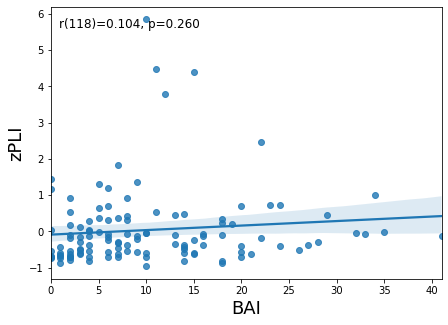

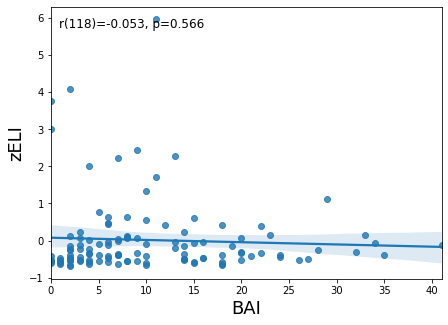

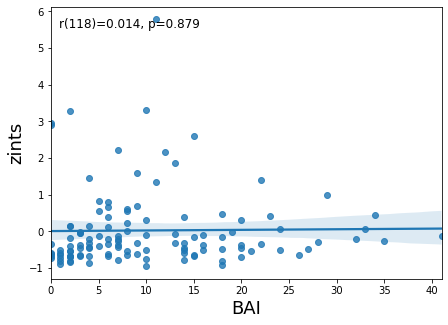

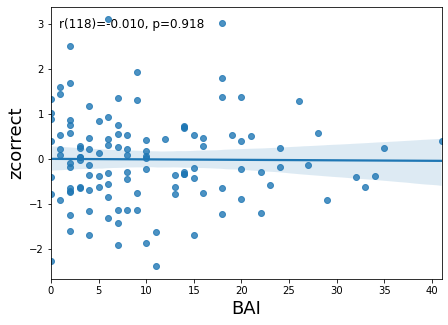

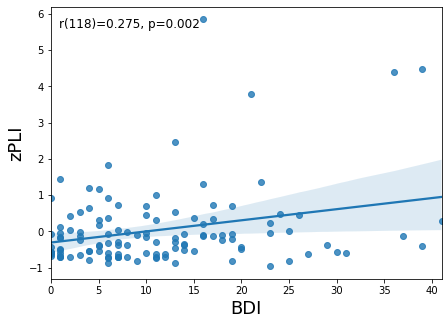

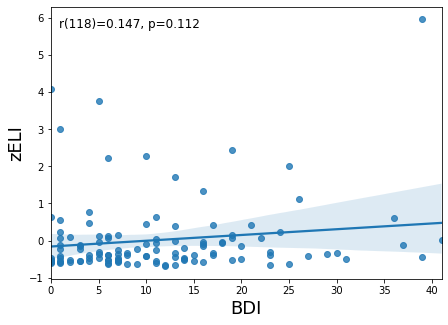

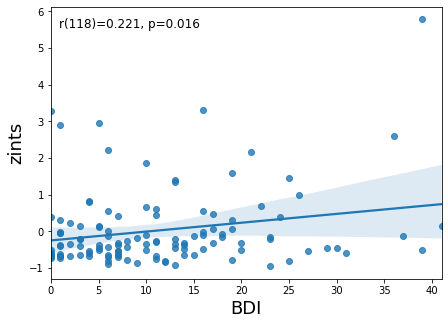

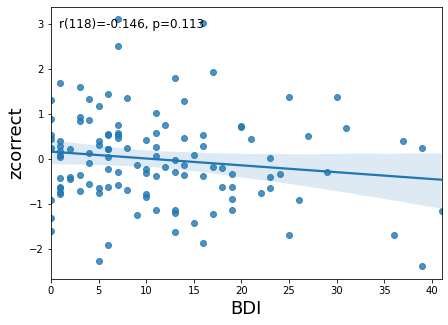

In [303]:
xs = ['BAI', 'BDI']
ys = ['zPLI', 'zELI', 'zints', 'zcorrect']
exp = 'both' 

#Generate graphs for normalized values vs BAI and BDI score
for xi in xs:
    for yi in ys:
        if exp == 'FR1':
            sel_df = full_df.query("experiment=='FR1'")
        elif exp == 'catFR1':
            sel_df = full_df.query("experiment=='catFR1'")
        elif exp == 'both':
            sel_df = full_df_comb

        x = sel_df[xi]
        y = sel_df[yi]
        n = len(sel_df)

        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d(coef)
        grad, inter, r, p, std_err = stats.linregress(x, y)

        plt.figure(figsize=(7, 5))
        # plt.scatter(x, y)
        # plt.plot(x, poly1d_fn(x), '--k')
        # max_x = round(x.max(axis = 0) + 5, 5)
        # max_y = round(y.max(axis = 0) + 5, 5)
        # plt.xticks(np.arange(0, max_x, 5))
        # plt.yticks(np.arange(0, max_y, 10))
        plt.xlabel(xi,fontsize=18)
        plt.ylabel(yi,fontsize=18)
#         print('r = ',r, 'p = ', p)
#         print('y =', grad, '*x + ', inter)
#         plt.text(x.min()+2, y.max()-1, f"p = " + str(round(p, 4)) + '\n' + "y = " + str(grad) + "*x + " + str(inter) + '\n' + 'R = ' + str(round(r, 4)) + '\n' + 'N = ' + str(n))
        plt.text(x.min()+float(np.ptp(x)/50), y.max()-float(np.ptp(y)/30), 'r(%.0f)=%.3f, p=%.3f '%(len(x)-1,r,p),fontsize=12)
        g = sb.regplot(data = df_filter, x=x, y=y)
#         plt.title(xi + ' vs ' + yi)
        #plt.savefig(xi +' vs '+ yi + ': ' + exp +'.pdf')
        # ax.set_xlim(0, 25)
        # ax.set_xticks(range(0,25), 5)
